In [130]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
import datetime
from scipy.optimize import curve_fit
plt.style.use("seaborn-v0_8-whitegrid")
from scipy import interpolate


def get_tick(df: pd.DataFrame, timestamp: int = None):
    """Function gets tick for each expiration and strike
    from closest timestamp from given. If timestamp is None, it takes last one."""
    if timestamp:
        data = df[df["timestamp"] <= timestamp].copy()
        # only not expired on curret tick
        data = data[data["expiration"] > timestamp].copy()
    else:
        data = df.copy()
        # only not expired on max available tick
        data = data[data["expiration"] > data["timestamp"].max()].copy()
    # tau is time before expiration in years
    data["tau"] = (data.expiration - data.timestamp) / 1e6 / 3600 / 24 / 365

    data_grouped = data.loc[
        data.groupby(["type", "expiration", "strike_price"])["timestamp"].idxmax()
    ]

    data_grouped = data_grouped[data_grouped["tau"] > 0.0]
    # We need Only out of the money to calibrate
    data_grouped = data_grouped[
        (
            (data_grouped["type"] == "call")
            & (data_grouped["underlying_price"] <= data_grouped["strike_price"])
        )
        | (
            (data_grouped["type"] == "put")
            & (data_grouped["underlying_price"] >= data_grouped["strike_price"])
        )
    ]
    data_grouped["mark_price_usd"] = (
        data_grouped["mark_price"] * data_grouped["underlying_price"]
    )
    data_grouped = data_grouped[data_grouped["strike_price"] <= 10_000]
    # print(data_grouped)
    return data_grouped

# Попробуем найти зависимость best_bid - best_ask ~ F(f, S)

In [6]:
df = pd.read_csv(f"../datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")
data = df.copy()
data = data[data["symbol"].str.startswith("ETH")]

In [122]:
prepr = get_tick(data, 1669895389325000)
exp = prepr[prepr["expiration"] == 1680249600000000][["strike_price", "bid_iv", 
                                                      "ask_iv", "mark_iv", "underlying_price", "type"]]
exp = exp.sort_values("strike_price")

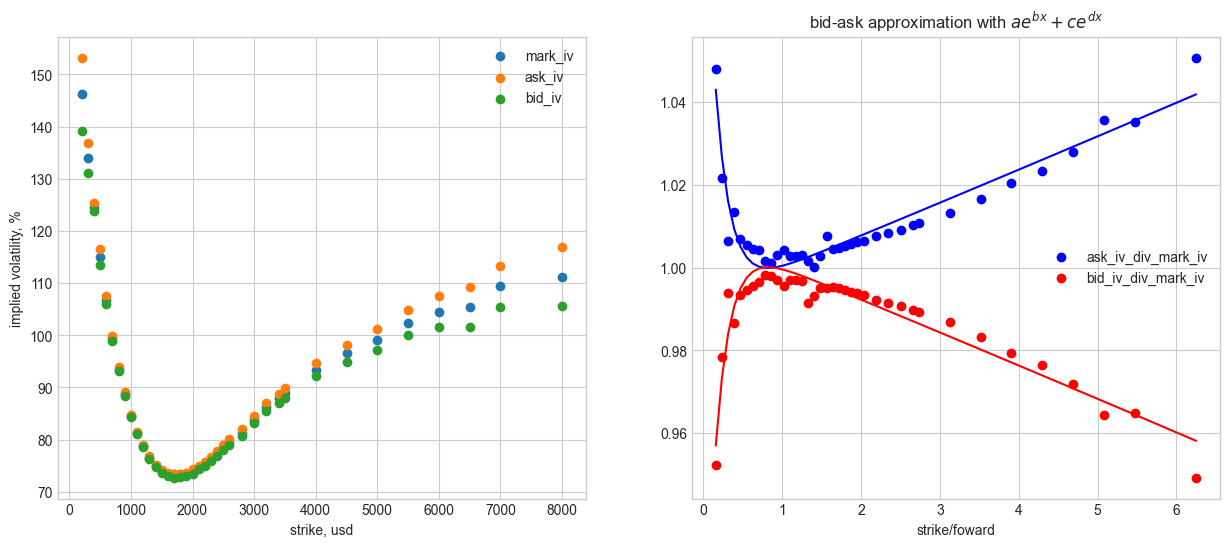

In [200]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 6)
ax1.scatter(exp["strike_price"], exp["mark_iv"], label = "mark_iv")
ax1.scatter(exp["strike_price"], exp["ask_iv"], label = "ask_iv")
ax1.scatter(exp["strike_price"], exp["bid_iv"], label = "bid_iv")
ax1.set_xlabel("strike, usd")
ax1.set_ylabel("implied volatility, %")

ax1.legend()

exp["strike_div_forward"] = exp["strike_price"]/exp["underlying_price"]
exp["bid_div_mark"] = exp["bid_iv"]/exp["mark_iv"]
exp["ask_div_mark"] = exp["ask_iv"]/exp["mark_iv"]
exp = exp[(exp["ask_div_mark"] <= 4) & (exp["bid_div_mark"] <= 4)]


ax2.scatter(exp["strike_div_forward"],
            exp["ask_div_mark"], label = "ask_iv_div_mark_iv", color = "blue")
ax2.scatter(exp["strike_div_forward"],
            exp["bid_div_mark"], label = "bid_iv_div_mark_iv", color = "red")


def func(x, a, b, c, d):
    return a*np.exp(b*x) + c*np.exp(d*x)
#     return (a*x**2 + b*x**1 + c + e*x**3)*np.exp(d*x)
#     return a*x**3 + b*x**2 + c*x + d
#     return a*x**2 + b*x**1 + c
#     return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 + f*x + g

# approximate 
xx = exp.strike_div_forward.values
popt, pcov = curve_fit(func, xx, exp.ask_div_mark.values)
exp["interp"] = func(xx, *popt)
ax2.plot(exp["strike_div_forward"], exp["interp"], color = "blue")
# it is just can be mirrored
ax2.plot(exp["strike_div_forward"], - exp["interp"] + 2, color = "red")
ax2.set_title(r"bid-ask approximation with $ae^{bx} + ce^{dx}$")
ax2.set_xlabel("strike/foward")
ax2.legend()



In [206]:
print("Functions params:", popt)

Functions params: [ 0.11482772 -5.35438945  0.99208757  0.00783973]


Видо, что чем больше разница между strike и forward, тем больше разница ask_iv - mark_iv и mark_iv - bid_iv. Посмотрим, как они отличаются

In [216]:
# теперь ясна зависимость. Можно захардкодить и переиспользовать, когда в данных нет bid_iv, ask_iv. 
exp.sample(5)

,strike_price,bid_iv,ask_iv,mark_iv,underlying_price,type,strike_div_forward,bid_div_mark,ask_div_mark,ask_interp,bid_interp,interp
10421930,5000,97.12,101.20,99.16,1279.94,call,3.906433,0.979427,1.020573,1.022941,0.976392,1.022941
10422832,1300,76.22,76.89,76.57,1279.95,call,1.015665,0.995429,1.004179,1.000518,0.994367,1.000518
10421787,1900,72.99,73.56,73.35,1279.94,call,1.484445,0.995092,1.002863,1.003741,0.996711,1.003741
10421916,700,98.88,99.96,99.41,1279.94,put,0.546901,0.994669,1.005533,1.002492,0.988437,1.002492
10422835,1500,73.66,74.10,73.89,1279.95,call,1.171921,0.996887,1.002842,1.001461,0.995528,1.001461


In [213]:
# find it for each available strike
approx_dict = {}
strikes_range = list(range(100, 10_000, 50))
for strike in strikes_range:
    approx_dict[strike] = max(func(strike/exp.underlying_price.mean(), *popt), 1.0)

In [214]:
# hardcode it 
approx_dict

{100: 1.0682687141911174,
 150: 1.0543091799098152,
 200: 1.043041829448211,
 250: 1.0339585615110631,
 300: 1.0266471731161493,
 350: 1.0207732598846047,
 400: 1.0160655324444303,
 450: 1.012303904194882,
 500: 1.0093098273690733,
 550: 1.006938453054222,
 600: 1.0050722709184021,
 650: 1.0036159493661156,
 700: 1.0024921495554828,
 750: 1.0016381294718064,
 800: 1.0010029889434058,
 850: 1.0005454346292013,
 900: 1.0002319668393267,
 950: 1.0000354085726098,
 1000: 1.0,
 1050: 1.0,
 1100: 1.0,
 1150: 1.0000351723918721,
 1200: 1.0001647525653266,
 1250: 1.0003277282334841,
 1300: 1.0005178140988367,
 1350: 1.0007299111473158,
 1400: 1.0009598827508623,
 1450: 1.0012043730280786,
 1500: 1.0014606594872277,
 1550: 1.0017265334811813,
 1600: 1.002000203225129,
 1650: 1.0022802151185861,
 1700: 1.0025653899169722,
 1750: 1.0028547709500737,
 1800: 1.003147582113679,
 1850: 1.003443193789814,
 1900: 1.0037410951991417,
 1950: 1.0040408719715295,
 2000: 1.0043421879499168,
 2050: 1.0046447